In this notebook you will find:

Linear Regession Model using Microsoft Data
XGBoost Regressor Model using Microsoft Data



BUILDING A LINEAR REGRESSION MODEL ON MICROSOFT

In [12]:
# Initial imports
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time
import pandas_datareader.data as web

from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook
from dotenv import load_dotenv
%matplotlib inline
import alpaca_trade_api as tradeapi
from sklearn.model_selection import train_test_split

In [13]:
load_dotenv()

True

In [14]:
# Set alpaca api key and secret 
# Set Alpaca API key and secret
alpaca_api_key = "AKJOSY68C1QODKIRO118"
alpaca_secret_key ="2laEO7wv0FwL5VoldeijGFWG7IbKpO8AxYCknAzX"
# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2"
)

In [15]:
# Set the tickers
microsoft = ["MSFT"]
timeframe = "1D"

In [16]:
# Format start and end dates as ISO format for five year period
start = pd.Timestamp("2017-06-01", tz="America/New_York").isoformat()
end = pd.Timestamp("2022-06-01", tz="America/New_York").isoformat()

In [17]:
# Get closing prices for MSFT from the five years
df_microsoft_daily = alpaca.get_bars(
    microsoft,
    timeframe,
    start = start,
    end = end,
    limit = 10000
).df

# Display sample data
df_microsoft_daily

,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2017-06-01 04:00:00+00:00,70.24,70.61,69.4510,70.10,21922908,115317,69.906282,MSFT
2017-06-02 04:00:00+00:00,70.44,71.86,70.2400,71.76,35470261,152145,71.359913,MSFT
2017-06-05 04:00:00+00:00,71.97,72.89,71.8100,72.28,33317996,137660,72.420495,MSFT
2017-06-06 04:00:00+00:00,72.30,72.62,72.2700,72.52,31511065,140546,72.465401,MSFT
2017-06-07 04:00:00+00:00,72.67,72.77,71.9500,72.39,22302769,122842,72.316942,MSFT
...,...,...,...,...,...,...,...,...
2022-05-25 04:00:00+00:00,258.36,264.58,257.1250,262.52,28402776,337552,260.950089,MSFT
2022-05-26 04:00:00+00:00,262.29,267.11,261.4294,265.90,24933202,296973,265.279916,MSFT
2022-05-27 04:00:00+00:00,268.51,273.34,267.5600,273.24,26809462,306101,271.652696,MSFT


In [18]:
# Create a new df filtering the index and close columns
#microsoft_signals_df = df_microsoft_daily.loc[:, ["close"]]

# Create a column for the daily returns
df_microsoft_daily["Return Percentage"] = df_microsoft_daily["close"].pct_change() 

# Drop all NaN values from the DataFrame
df_microsoft_daily = df_microsoft_daily.dropna()

# Show signals df
display(df_microsoft_daily.head())
display(df_microsoft_daily.tail())

,open,high,low,close,volume,trade_count,vwap,symbol,Return Percentage
timestamp,,,,,,,,,
2017-06-02 04:00:00+00:00,70.44,71.86,70.24,71.76,35470261,152145,71.359913,MSFT,0.023680
2017-06-05 04:00:00+00:00,71.97,72.89,71.81,72.28,33317996,137660,72.420495,MSFT,0.007246
2017-06-06 04:00:00+00:00,72.30,72.62,72.27,72.52,31511065,140546,72.465401,MSFT,0.003320
2017-06-07 04:00:00+00:00,72.67,72.77,71.95,72.39,22302769,122842,72.316942,MSFT,-0.001793
2017-06-08 04:00:00+00:00,72.42,72.52,71.50,71.95,26179442,136478,71.981665,MSFT,-0.006078


,open,high,low,close,volume,trade_count,vwap,symbol,Return Percentage
timestamp,,,,,,,,,
2022-05-25 04:00:00+00:00,258.36,264.58,257.1250,262.52,28402776,337552,260.950089,MSFT,0.011170
2022-05-26 04:00:00+00:00,262.29,267.11,261.4294,265.90,24933202,296973,265.279916,MSFT,0.012875
2022-05-27 04:00:00+00:00,268.51,273.34,267.5600,273.24,26809462,306101,271.652696,MSFT,0.027604
2022-05-31 04:00:00+00:00,272.50,274.77,268.9300,271.87,37691020,361137,271.999157,MSFT,-0.005014
2022-06-01 04:00:00+00:00,275.00,277.69,270.0400,272.42,25108530,318649,273.328471,MSFT,0.002023


In [19]:
new_df = df_microsoft_daily.loc[:, ['open', 'high', 'low', 'close', 'vwap', 'symbol', 'Return Percentage']]
new_df


# EWMA indicators
short_span = 9
long_span = 20


new_df['9EWMA'] = df_microsoft_daily.loc[:, 'close'].ewm(span= short_span).mean()
new_df['20EWMA'] = df_microsoft_daily.loc[:, 'close'].ewm(span= long_span).mean()
new_df

,open,high,low,close,vwap,symbol,Return Percentage,9EWMA,20EWMA
timestamp,,,,,,,,,
2017-06-02 04:00:00+00:00,70.44,71.86,70.2400,71.76,71.359913,MSFT,0.023680,71.760000,71.760000
2017-06-05 04:00:00+00:00,71.97,72.89,71.8100,72.28,72.420495,MSFT,0.007246,72.048889,72.033000
2017-06-06 04:00:00+00:00,72.30,72.62,72.2700,72.52,72.465401,MSFT,0.003320,72.241967,72.211823
2017-06-07 04:00:00+00:00,72.67,72.77,71.9500,72.39,72.316942,MSFT,-0.001793,72.292114,72.263260
2017-06-08 04:00:00+00:00,72.42,72.52,71.5000,71.95,71.981665,MSFT,-0.006078,72.190343,72.187485
...,...,...,...,...,...,...,...,...,...
2022-05-25 04:00:00+00:00,258.36,264.58,257.1250,262.52,260.950089,MSFT,0.011170,260.540791,266.336119
2022-05-26 04:00:00+00:00,262.29,267.11,261.4294,265.90,265.279916,MSFT,0.012875,261.612633,266.294584
2022-05-27 04:00:00+00:00,268.51,273.34,267.5600,273.24,271.652696,MSFT,0.027604,263.938106,266.956052


In [20]:
# Create column "Signal" such that if 8EWMA is gerater than 20EWMA then set sugnal to 1, else 
new_df['Signal'] = 0.0
new_df['Signal'] = np.where(new_df['9EWMA'] > new_df['20EWMA'], 1.0, 0.0)

new_df

,open,high,low,close,vwap,symbol,Return Percentage,9EWMA,20EWMA,Signal
timestamp,,,,,,,,,,
2017-06-02 04:00:00+00:00,70.44,71.86,70.2400,71.76,71.359913,MSFT,0.023680,71.760000,71.760000,0.0
2017-06-05 04:00:00+00:00,71.97,72.89,71.8100,72.28,72.420495,MSFT,0.007246,72.048889,72.033000,1.0
2017-06-06 04:00:00+00:00,72.30,72.62,72.2700,72.52,72.465401,MSFT,0.003320,72.241967,72.211823,1.0
2017-06-07 04:00:00+00:00,72.67,72.77,71.9500,72.39,72.316942,MSFT,-0.001793,72.292114,72.263260,1.0
2017-06-08 04:00:00+00:00,72.42,72.52,71.5000,71.95,71.981665,MSFT,-0.006078,72.190343,72.187485,1.0
...,...,...,...,...,...,...,...,...,...,...
2022-05-25 04:00:00+00:00,258.36,264.58,257.1250,262.52,260.950089,MSFT,0.011170,260.540791,266.336119,0.0
2022-05-26 04:00:00+00:00,262.29,267.11,261.4294,265.90,265.279916,MSFT,0.012875,261.612633,266.294584,0.0
2022-05-27 04:00:00+00:00,268.51,273.34,267.5600,273.24,271.652696,MSFT,0.027604,263.938106,266.956052,0.0


In [21]:
#Reimport the libraries
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_datareader.data as web
import time

from datetime import *
from matplotlib import pyplot as plt

from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import *
from tqdm import tqdm_notebook
from xgboost import XGBRegressor
%matplotlib inline

In [22]:
test_size = 0.2                 # proportion of dataset to be used as test set
cv_size = 0.2                   # proportion of dataset to be used as cross-validation set
Nmax = 30                       # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
                                # Nmax is the maximum N we are going to test
fontsize = 14
ticklabelsize = 14

In [24]:
def get_preds_lin_reg(df, target_col, N, pred_min, offset):

    regr = LinearRegression(fit_intercept=True)

    pred_list = []
    
    for i in range(offset, len(df['close'])):
        X_train = np.array(range(len(df['close'][i-N:i]))) 
        y_train = np.array(df['close'][i-N:i]) 
        X_train = X_train.reshape(-1, 1)     
              
        y_train = y_train.reshape(-1, 1)
    #     print X_train.shape
    #     print y_train.shape
    #     print 'X_train = \n' + str(X_train)
    #     print 'y_train = \n' + str(y_train)
        regr.fit(X_train, y_train)            
        pred = regr.predict(np.array(N).reshape(1,-1))
    
        pred_list.append(pred[0][0])  
    
    # If the values are < pred_min, set it to be pred_min
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min

    return pred_list

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [25]:
new_df.columns

Index(['open', 'high', 'low', 'close', 'vwap', 'symbol', 'Return Percentage',
       '9EWMA', '20EWMA', 'Signal'],
      dtype='object')

In [26]:
new_df['date']=new_df.index
new_df['date'] = pd.to_datetime(new_df['date'],format='%Y-%m-%d')
start = datetime(2017, 1, 6)
end = datetime(2022, 1,6)

In [27]:
new_df=new_df.reset_index(drop=True)
new_df.head()
new_df["date"] = pd.to_datetime(new_df["date"]).dt.date
new_df

,open,high,low,close,vwap,symbol,Return Percentage,9EWMA,20EWMA,Signal,date
0,70.44,71.86,70.2400,71.76,71.359913,MSFT,0.023680,71.760000,71.760000,0.0,2017-06-02
1,71.97,72.89,71.8100,72.28,72.420495,MSFT,0.007246,72.048889,72.033000,1.0,2017-06-05
2,72.30,72.62,72.2700,72.52,72.465401,MSFT,0.003320,72.241967,72.211823,1.0,2017-06-06
3,72.67,72.77,71.9500,72.39,72.316942,MSFT,-0.001793,72.292114,72.263260,1.0,2017-06-07
4,72.42,72.52,71.5000,71.95,71.981665,MSFT,-0.006078,72.190343,72.187485,1.0,2017-06-08
...,...,...,...,...,...,...,...,...,...,...,...
1254,258.36,264.58,257.1250,262.52,260.950089,MSFT,0.011170,260.540791,266.336119,0.0,2022-05-25
1255,262.29,267.11,261.4294,265.90,265.279916,MSFT,0.012875,261.612633,266.294584,0.0,2022-05-26
1256,268.51,273.34,267.5600,273.24,271.652696,MSFT,0.027604,263.938106,266.956052,0.0,2022-05-27
1257,272.50,274.77,268.9300,271.87,271.999157,MSFT,-0.005014,265.524485,267.424047,0.0,2022-05-31


In [28]:
new_df.columns

Index(['open', 'high', 'low', 'close', 'vwap', 'symbol', 'Return Percentage',
       '9EWMA', '20EWMA', 'Signal', 'date'],
      dtype='object')

Text(0.5, 0, 'date')

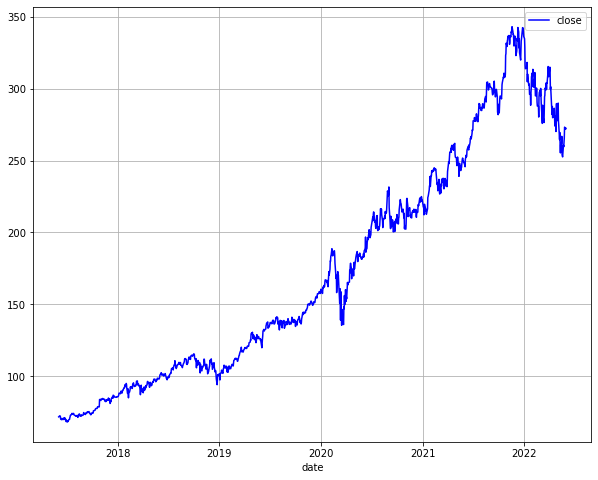

In [29]:
#Plot the close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = new_df.plot(x='date', y='close', style='b-', grid=True)
ax.set_xlabel("date")

In [30]:
#build the sizes of each dataset that will be used
num_cv = int(cv_size*len(new_df))
num_test = int(test_size*len(new_df))
num_train = len(new_df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = new_df[:num_train].copy()
cv = new_df[num_train:num_train+num_cv].copy()
train_cv = new_df[:num_train+num_cv].copy()
test = new_df[num_train+num_cv:].copy()
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 757
num_cv = 251
num_test = 251
train.shape = (757, 11)
cv.shape = (251, 11)
train_cv.shape = (1008, 11)
test.shape = (251, 11)


Text(0, 0.5, 'USD')

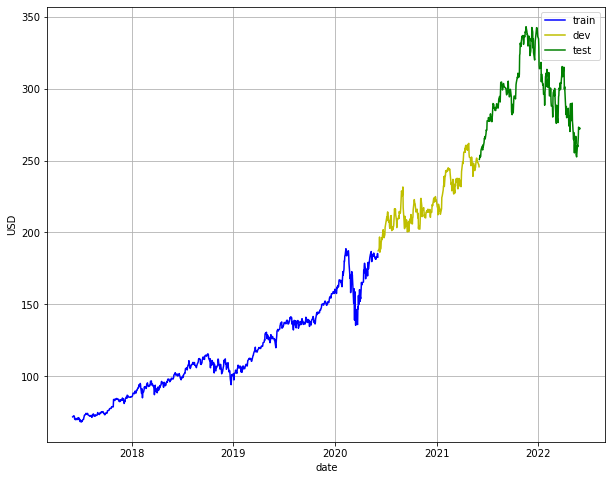

In [31]:
# Plot the dataset of train, dev, and test over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [32]:
#get the Root Mean Square Error and the Mean absolute percentage error
RMSE = []
R2 = []
mape = []
for N in range(1, Nmax+1): # N is no. of samples to use to predict the next value
    est_list = get_preds_lin_reg(train_cv, 'close', N, 0, num_train)
    
    cv.loc[:, 'est' + '_N' + str(N)] = est_list
    RMSE.append(math.sqrt(mean_squared_error(est_list, cv['close'])))
    R2.append(r2_score(cv['close'], est_list))
    mape.append(get_mape(cv['close'], est_list))
print('RMSE = ' + str(RMSE))
print('R2 = ' + str(R2))
print('MAPE = ' + str(mape))
cv.head()

RMSE = [3.830017371726802, 5.752355173304294, 4.748792940921969, 4.624388405777573, 4.53090631813824, 4.615742895674866, 4.792873376807935, 4.991908045388306, 5.098999586088792, 5.161258449510854, 5.256229593403715, 5.348805332349159, 5.479251145844567, 5.6425506406758075, 5.8305643351455245, 6.033360042331171, 6.218961605010544, 6.401514189285648, 6.548801852917421, 6.679393099278694, 6.786949582060921, 6.873382254349307, 6.9565968851577855, 7.039554408961912, 7.127242149779509, 7.224540529669156, 7.34527916635775, 7.4667434862490385, 7.589102456609606, 7.699666200377615]
R2 = [0.954866260315075, 0.8981898168581703, 0.9306148870655487, 0.9342026444292437, 0.9368359457934496, 0.934448436912503, 0.929320780807925, 0.9233286720027528, 0.9200037211544028, 0.9180382833593348, 0.9149942142236076, 0.9119735036027727, 0.9076275959868672, 0.9020395518955954, 0.8954025695664918, 0.8879999239441312, 0.8810031176617137, 0.8739144674664797, 0.8680457044550487, 0.862730567178996, 0.8582741474741494

,open,high,low,close,vwap,symbol,Return Percentage,9EWMA,20EWMA,Signal,...,est_N21,est_N22,est_N23,est_N24,est_N25,est_N26,est_N27,est_N28,est_N29,est_N30
757,182.47,187.73,182.0100,187.20,185.920358,MSFT,0.023398,184.176476,182.459116,1.0,...,183.330714,183.553636,183.894585,184.517464,184.6384,184.861323,185.595128,185.881429,186.065320,186.407310
758,185.61,188.55,184.4400,188.36,186.742662,MSFT,0.006197,185.013181,183.021105,1.0,...,183.998905,184.039610,184.222253,184.522572,185.0985,185.198277,185.398348,186.093571,186.362094,186.533793
759,188.07,190.70,187.2605,189.80,189.309536,MSFT,0.007645,185.970545,183.666714,1.0,...,184.937571,184.837792,184.842253,184.985978,185.2467,185.776862,185.854359,186.030556,186.687217,186.936368
760,191.10,198.52,191.0100,196.84,195.313660,MSFT,0.037092,188.144436,184.921312,1.0,...,186.200810,185.932338,185.798458,185.766775,185.8717,186.092769,186.577350,186.630794,186.781478,187.398920
761,193.13,195.76,186.0700,186.27,190.169706,MSFT,-0.053698,187.769549,185.049759,1.0,...,188.957476,188.338571,187.997668,187.790326,187.6863,187.719046,187.869430,188.279841,188.280887,188.379609


Text(0, 0.5, 'RMSE')

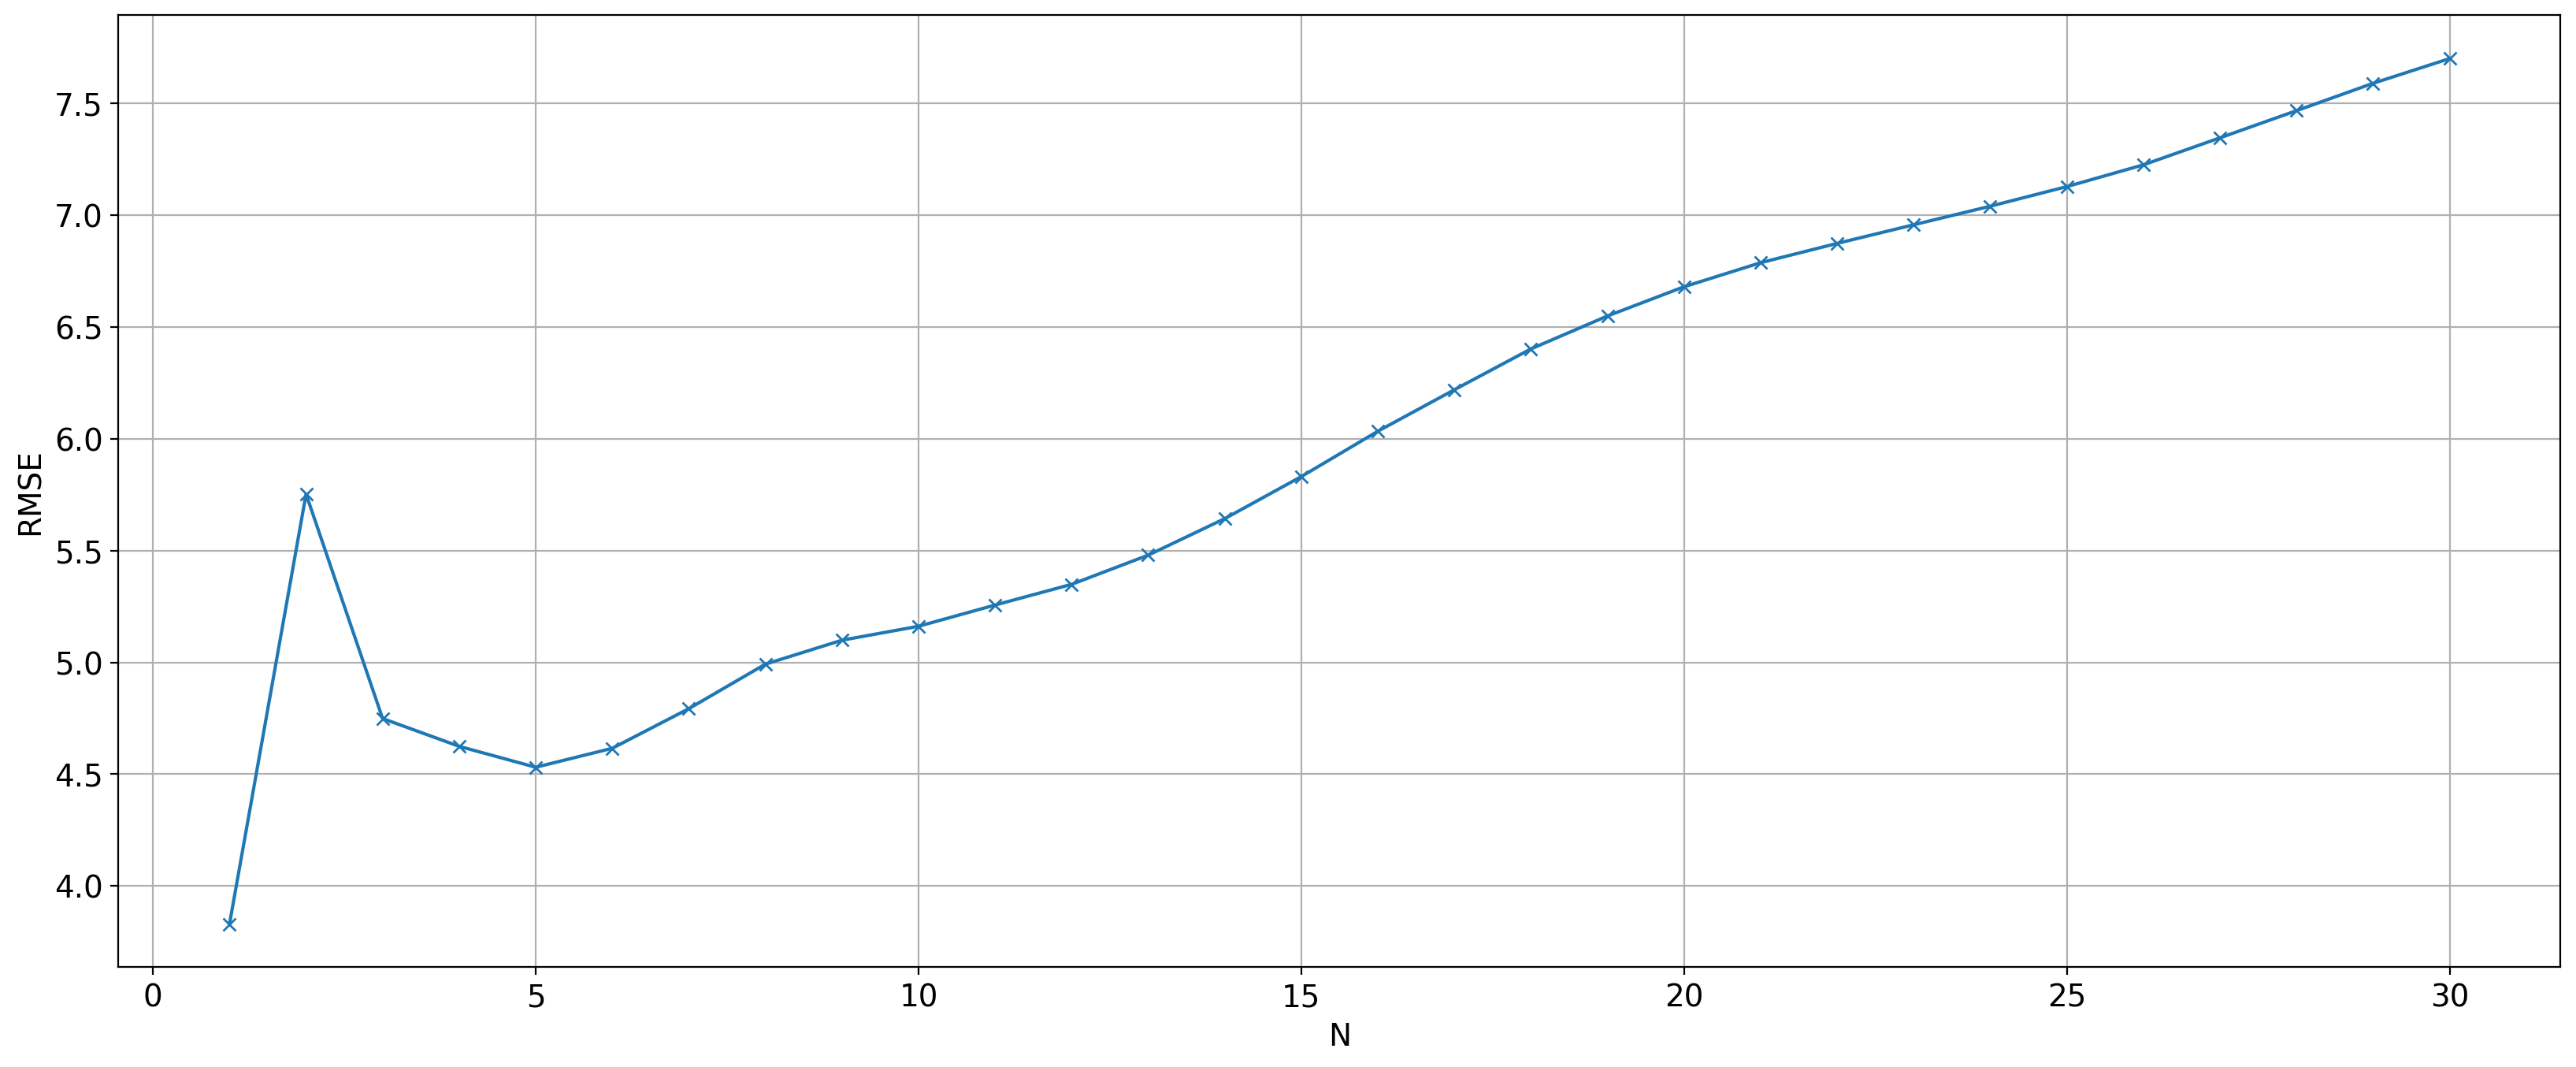

In [33]:
# Plot RMSE versus N
matplotlib.rcParams.update({'font.size': 14})
plt.figure(figsize=(20, 8), dpi=200)
plt.plot(range(1, Nmax+1), RMSE, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('RMSE')
#plt.xlim([2, 30])

Plot Prediction on the dev set of data

Text(0, 0.5, 'USD')

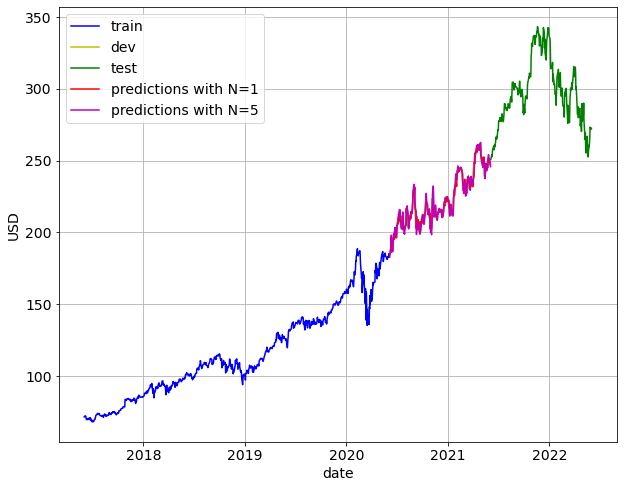

In [36]:
# Plot predictions on the dev set of data
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='r-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N5', style='m-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N=1', 'predictions with N=5'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

A quick view of the of the dev set of data

Text(0.5, 1.0, 'Zoom in to dev set')

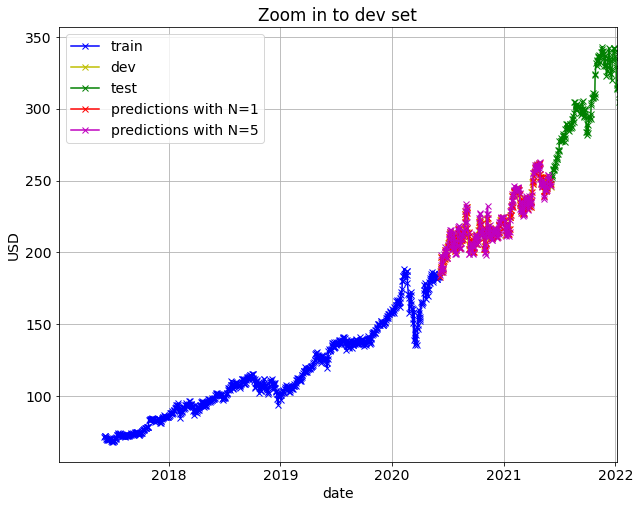

In [37]:
# Plot close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='close', style='bx-', grid=True)
ax = cv.plot(x='date', y='close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='gx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='rx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N5', style='mx-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N=1', 'predictions with N=5'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2017, 1, 6), date(2022, 1, 6)])
#ax.set_ylim([127, 137])
ax.set_title('Zoom in to dev set')

Here you will see our final Linear Regression Model

In [40]:
N_opt = 5
est_list = get_preds_lin_reg(new_df, 'close', N_opt, 0, num_train+num_cv)
test.loc[:, 'est' + '_N' + str(N_opt)] = est_list
print("RMSE = %0.3f" % math.sqrt(mean_squared_error(est_list, test['close'])))
print("R2 = %0.3f" % r2_score(test['close'], est_list))
print("MAPE = %0.3f%%" % get_mape(test['close'], est_list))
test.head()

RMSE = 6.077
R2 = 0.931
MAPE = 1.590%


,open,high,low,close,vwap,symbol,Return Percentage,9EWMA,20EWMA,Signal,date,est_N5
1008,247.88,251.65,247.51,250.79,250.214451,MSFT,0.020675,248.366611,248.418978,0.0,2021-06-04,245.006
1009,249.95,254.09,249.81,253.81,252.662218,MSFT,0.012042,249.455289,248.932409,1.0,2021-06-07,248.335
1010,255.25,256.01,252.51,252.57,253.568635,MSFT,-0.004886,250.078231,249.278846,1.0,2021-06-08,253.895
1011,254.01,255.53,253.21,253.59,254.211167,MSFT,0.004038,250.780585,249.689432,1.0,2021-06-09,255.628
1012,254.00,257.46,253.67,257.24,256.427341,MSFT,0.014393,252.072468,250.408534,1.0,2021-06-10,256.556


Text(0, 0.5, 'USD')

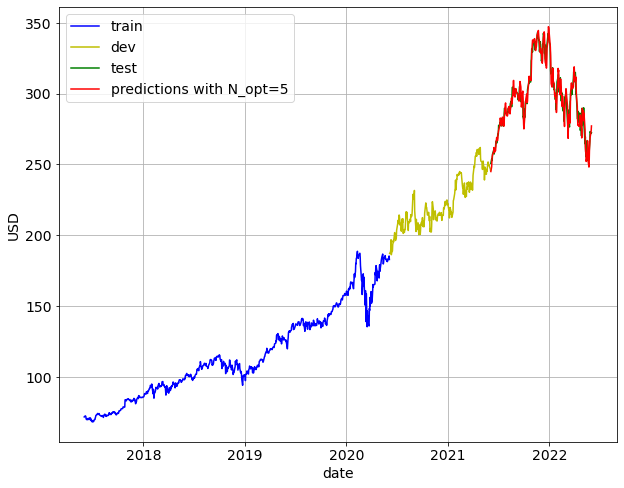

In [41]:
#Using test data on the model
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N5', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N_opt=5'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to test set')

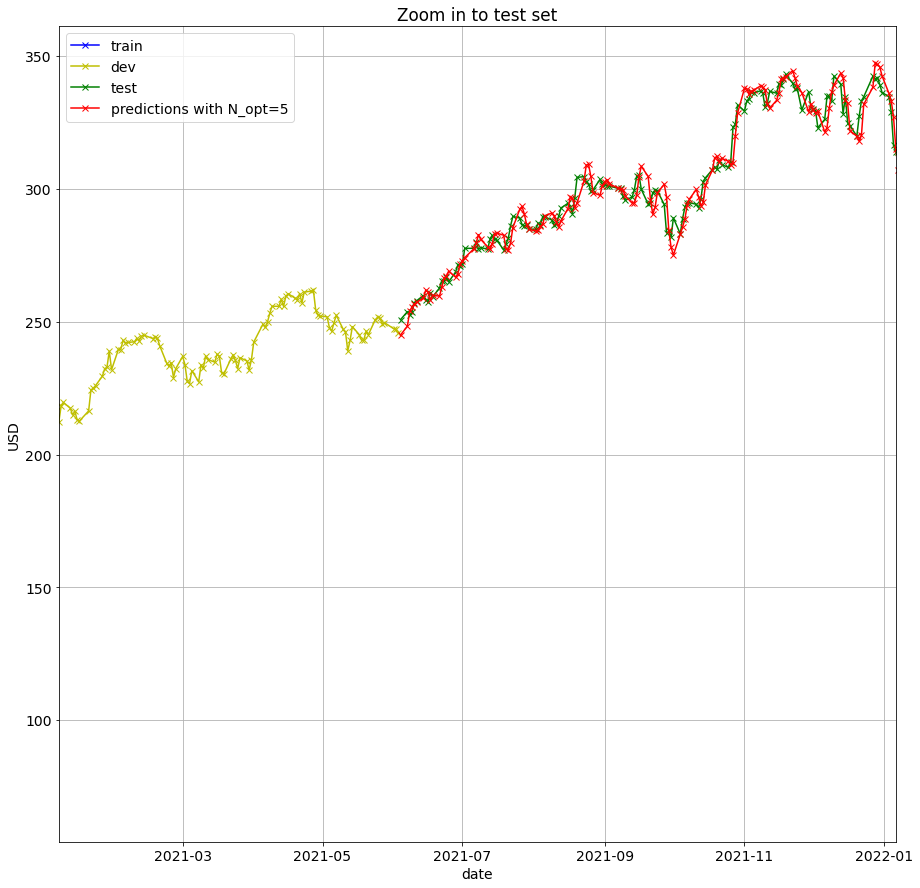

In [50]:
# Plot close over time on test data
rcParams['figure.figsize'] = 15, 15 # width 10, height 8

ax = train.plot(x='date', y='close', style='bx-', grid=True)
ax = cv.plot(x='date', y='close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='gx-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N5', style='rx-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N_opt=5'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2021,1,6), date(2022, 1, 6)])
#ax.set_ylim([135, 150])
ax.set_title('Zoom in to test set')

BUILDING XGBOOST REGRESSION MODEL ON MICROSOFT DATA

In [51]:
#Import Libraries 
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_datareader.data as web
import time

from datetime import *
from matplotlib import pyplot as plt

from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import *
from tqdm import tqdm_notebook
from xgboost import XGBRegressor
%matplotlib inline
